# Perform machine learning by training on measurements data using unimodal LSTM architecture


## Read data

In [1]:
import os
from pathlib import Path

import pandas as pd


dataDirName = Path(os.environ['DATA_DIR'], 'sepsis_prediction', 'lstm_initial_trials', '02_data_matrix', 'balanced_data')
dataDirName.mkdir(exist_ok=True, parents=True)

dataDf = pd.read_csv(Path(dataDirName, 'data.csv'))
dataDf = dataDf.sort_values(by=['PATIENT_ID', 'EPISODE_ID', 'measurement_datetime'], ascending=True)
dataDf

,PATIENT_ID,EPISODE_ID,measurement_datetime,Diastolic blood pressure_mean,Diastolic blood pressure_min,Diastolic blood pressure_max,Diastolic blood pressure_first,Diastolic blood pressure_last,Diastolic blood pressure_std,Heart rate_mean,...,Phosphate measurement_std,Magnesium measurement_mean,Magnesium measurement_min,Magnesium measurement_max,Magnesium measurement_first,Magnesium measurement_last,Magnesium measurement_std,Organism_FIRST_NOTED,sepsis,target
0,51211,17422049,2023-02-18,54.000000,54.000000,54.0,54.000000,54.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023-04-01,0.0,0.0
1,51211,17422049,2023-02-19,54.000000,54.000000,54.0,54.000000,54.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023-04-01,0.0,0.0
2,51211,17422049,2023-02-20,54.000000,54.000000,54.0,54.000000,54.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023-04-01,0.0,0.0
3,56089,14164983,2020-12-07,55.285714,39.000000,80.0,48.000000,51.000000,16.948100,79.000000,...,0.070711,0.767143,0.766667,0.767619,0.766667,0.767619,0.014142,2020-12-07,0.0,0.0
4,56089,14164983,2020-12-08,58.285714,34.000000,86.0,34.000000,70.000000,20.171880,70.833333,...,0.070711,0.810000,0.810000,0.810000,0.810000,0.810000,0.014142,2020-12-07,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231552,2662222,17201307,2022-12-30,58.647186,53.285714,66.0,59.285714,58.428571,5.213477,120.880000,...,0.234087,0.910000,0.910000,0.910000,0.910000,0.910000,0.108044,2022-12-21,0.0,0.0
231553,2662222,17201307,2022-12-31,58.647186,53.285714,66.0,59.285714,58.428571,5.213477,129.120000,...,0.183848,1.050000,1.010000,1.090000,1.090000,1.010000,0.056569,2022-12-21,0.0,0.0
231554,2662222,17201307,2023-01-01,58.647186,53.285714,66.0,59.285714,58.428571,5.213477,126.000000,...,0.234087,0.900000,0.900000,0.900000,0.900000,0.900000,0.108044,2022-12-21,0.0,0.0
231555,2662222,17201307,2023-01-02,58.647186,53.285714,66.0,59.285714,58.428571,5.213477,64.400000,...,0.234087,3.500000,3.500000,3.500000,3.500000,3.500000,0.108044,2022-12-21,0.0,0.0


## Perform ML

### Prepare data

In [2]:
rowsX = []
rowsY = []
for name, group in dataDf.groupby(by=['PATIENT_ID', 'EPISODE_ID']):
    low = 0
    high = 3
    while high <= group.shape[0]:
        valuesList = []
        for col in dataDf.columns[~dataDf.columns.isin(['PATIENT_ID', 'EPISODE_ID', 'measurement_datetime', 'Organism_FIRST_NOTED', 'sepsis', 'target'])]:
            valuesList.append(list(group[col][low: high]))
        rowsX.append(
            [[*x] for x in zip(*valuesList)]
            )
        rowsY.append(group.target[(high - 1): high].values[0])
        high += 1
        low += 1

In [3]:
import numpy as np


X = np.array(rowsX)
Y = np.array(rowsY)

In [4]:
X.shape, Y.shape

((225965, 3, 222), (225965,))

In [5]:
np.unique(Y, return_counts=True)[1]/Y.shape[0]

array([0.53638395, 0.46361605])

In [6]:
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((180772, 3, 222), (45193, 3, 222), (180772,), (45193,))

### NB Classifier model

In [7]:
from sklearn.naive_bayes import GaussianNB


gnb = GaussianNB()
y_score = gnb.fit(X_train.reshape((X_train.shape[0], 3*X.shape[2])), Y_train).predict_proba(X_test.reshape((X_test.shape[0], 3*X.shape[2])))
y_pred = gnb.fit(X_train.reshape((X_train.shape[0], 3*X.shape[2])), Y_train).predict(X_test.reshape((X_test.shape[0], 3*X.shape[2])))

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score


print('Accuracy', accuracy_score(Y_test, y_pred))
print('Balanced Accuracy', balanced_accuracy_score(Y_test, y_pred))
print('F1 Score', f1_score(Y_test, y_pred))
print('Precision Score', precision_score(Y_test, y_pred))
print('Recall Score', recall_score(Y_test, y_pred))
print('roc_auc_score', roc_auc_score(Y_test, [y[1] for y in y_score]))

Accuracy 0.44562210961874626
Balanced Accuracy 0.5542909544409463
F1 Score 0.5359511020559363
Precision Score 0.37885254916337163
Recall Score 0.9156382507436238
roc_auc_score 0.5751964978081878


### LR Classifier

In [9]:
from sklearn.linear_model import LogisticRegression


lrc = LogisticRegression(random_state=0)
y_score = lrc.fit(X_train.reshape((X_train.shape[0], 3*X.shape[2])), Y_train).predict_proba(X_test.reshape((X_test.shape[0], 3*X.shape[2])))
y_pred = lrc.fit(X_train.reshape((X_train.shape[0], 3*X.shape[2])), Y_train).predict(X_test.reshape((X_test.shape[0], 3*X.shape[2])))

/home/vmadmin/workspace/sepsis_predictor/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vmadmin/workspace/sepsis_predictor/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


print('Accuracy', accuracy_score(Y_test, y_pred))
print('Balanced Accuracy', balanced_accuracy_score(Y_test, y_pred))
print('F1 Score', f1_score(Y_test, y_pred))
print('Precision Score', precision_score(Y_test, y_pred))
print('Recall Score', recall_score(Y_test, y_pred))
print('roc_auc_score', roc_auc_score(Y_test, [y[1] for y in y_score]))

Accuracy 0.6157369504126745
Balanced Accuracy 0.6043786156909303
F1 Score 0.5076547970061238
Precision Score 0.4598120281444199
Recall Score 0.5666097082463135
roc_auc_score 0.63911794875134


### XGBoost Classifier

In [11]:
from xgboost import XGBClassifier

bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train.reshape((X_train.shape[0], 3*X.shape[2])), Y_train)
# make predictions
y_score = bst.predict_proba(X_test.reshape((X_test.shape[0], 3*X.shape[2])))
y_pred = bst.predict(X_test.reshape((X_test.shape[0], 3*X.shape[2])))

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


print('Accuracy', accuracy_score(Y_test, y_pred))
print('Balanced Accuracy', balanced_accuracy_score(Y_test, y_pred))
print('F1 Score', f1_score(Y_test, y_pred))
print('Precision Score', precision_score(Y_test, y_pred))
print('Recall Score', recall_score(Y_test, y_pred))
print('roc_auc_score', roc_auc_score(Y_test, [y[1] for y in y_score]))

Accuracy 0.6664085145929679
Balanced Accuracy 0.6285270734399816
F1 Score 0.5130176367982427
Precision Score 0.5239163422840931
Recall Score 0.5025631289158914
roc_auc_score 0.673326210990002


### LSTM using Pytorch

In [13]:
import torch
from torch import nn
import torch.utils.data as data

In [14]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

loader = data.DataLoader(data.TensorDataset(X_train_tensor, Y_train_tensor), shuffle=False, batch_size=1024)

In [15]:
print(X_train_tensor.shape, Y_train_tensor.shape, X_test_tensor.shape, Y_test_tensor.shape)

torch.Size([180772, 3, 222]) torch.Size([180772]) torch.Size([45193, 3, 222]) torch.Size([45193])


In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [31]:
class LstmModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=X.shape[2], hidden_size=256, num_layers=1, batch_first=True)
        self.linear1 = nn.Linear(256, 1)
        # self.relu = nn.LeakyReLU(0.01)
        # self.ln = nn.LayerNorm(64)

        # self.linear2 = nn.Linear(64, 1)

    def forward(self, x):

        out, _ = self.lstm(x)          # -> (batch_size, seq_len, n_hidden)
        out = out[:, -1, :]

        out = self.linear1(out)                  # -> (batch_size * seq_len, vocab_size)
        # out = self.relu(out)
        # out = self.ln(out)

        # out = self.linear2(out)

        return out

In [32]:
model = LstmModel().to(device)
model

LstmModel(
  (lstm): LSTM(222, 256, batch_first=True)
  (linear1): Linear(in_features=256, out_features=1, bias=True)
)

In [33]:
learning_rate = 1e-3

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-3) # 

In [34]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

#### Distribution of Weights and Biases

##### Weights

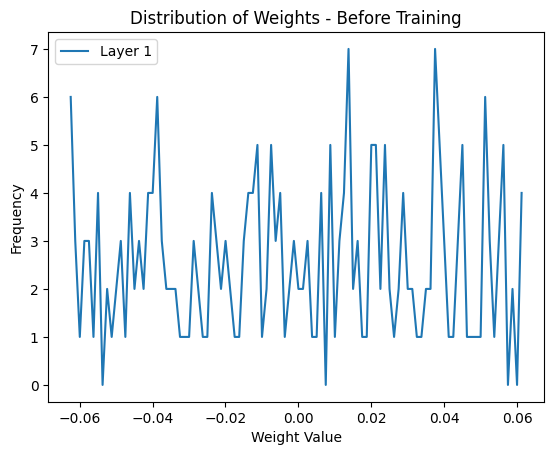

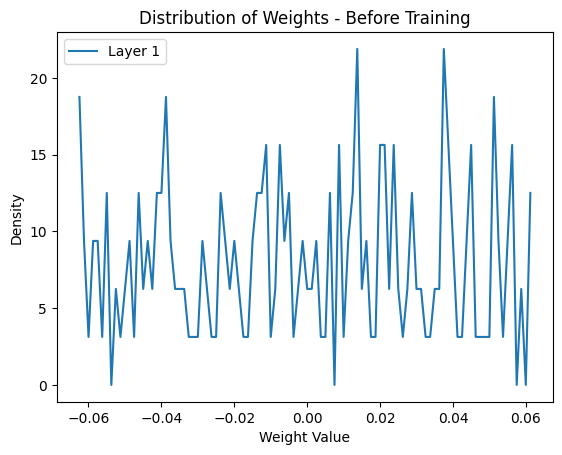

In [35]:
import sys
import os

sys.path.append(os.path.join(os.environ['SEPSIS_PREDICTOR_BASE'], "src"))

import Utils

plotData = {}
plotData['Layer 1'] = model.linear1.weight.data.flatten()
# plotData['Layer 2'] = model.linear2.weight.data.flatten()
# plotData['Layer 3'] = model.linear3.weight.data.flatten()

plt1 = Utils.plotWeightsDistribution(data=plotData, density=False, dataType="Weights", titlePrefix='Before Training')
plt1.show()

plt2 = Utils.plotWeightsDistribution(data=plotData, density=True, dataType="Weights", titlePrefix='Before Training')
plt2.show()

##### Biases

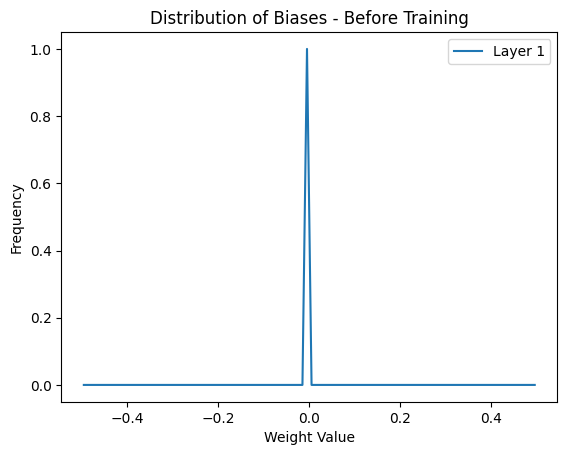

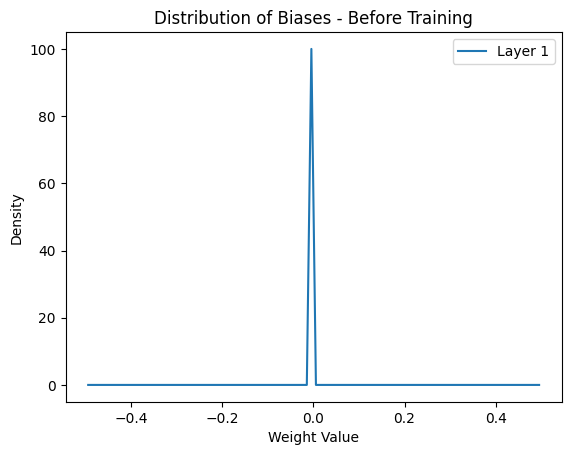

In [36]:
import sys
import os

sys.path.append(os.path.join(os.environ['SEPSIS_PREDICTOR_BASE'], "src"))

import Utils


plotData = {}
plotData['Layer 1'] = model.linear1.bias.data.flatten()
# plotData['Layer 2'] = model.linear2.bias.data.flatten()
# plotData['Layer 3'] = model.linear3.bias.data.flatten()

plt1 = Utils.plotWeightsDistribution(data=plotData, density=False, dataType="Biases", titlePrefix='Before Training')
plt1.show()

plt1 = Utils.plotWeightsDistribution(data=plotData, density=True, dataType="Biases", titlePrefix='Before Training')
plt1.show()

#### Distribution of activations

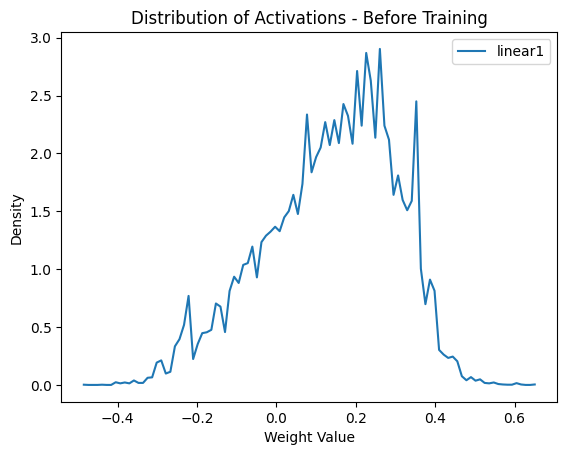

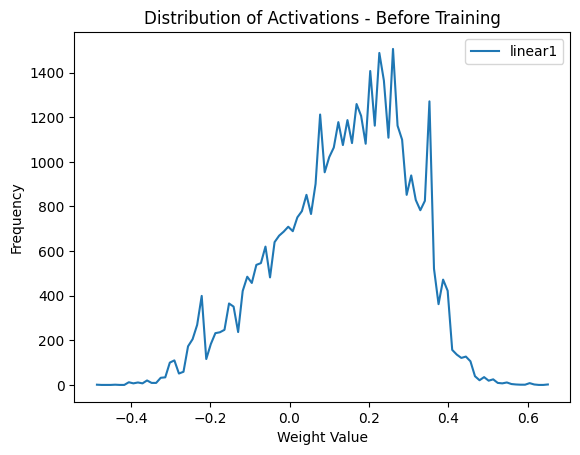

In [37]:
import sys
import os

sys.path.append(os.path.join(os.environ['SEPSIS_PREDICTOR_BASE'], "src"))

import Utils

activation = {}

def get_activation(name):
    def hook(module, input, output):
        activation[name] = output.detach()
    return hook

# Register the hooks
handle1 = model.linear1.register_forward_hook(get_activation('linear1'))
# handle2 = model.linear2.register_forward_hook(get_activation('linear2'))
# handle3 = model.linear3.register_forward_hook(get_activation('linear3'))

# Perform forward pass to get activations
with torch.no_grad():
    output = model(X_test_tensor)

handle1.remove()
# handle2.remove()
# handle3.remove()

plt1 = Utils.plotActivationDistribution(activation=activation, density=True, dataType="Activations", titlePrefix='Before Training')
plt1.show()

plt2 = Utils.plotActivationDistribution(activation=activation, density=False, dataType="Activations", titlePrefix='Before Training')
plt2.show()



#### Train and evaluate

In [38]:
# Number of epochs
epochs = 20

# Send data to the device
x_train, x_valid = X_train_tensor.to(device), X_test_tensor.to(device)
y_train, y_valid = Y_train_tensor.to(device), Y_test_tensor.to(device)

# Empty loss lists to track values
epoch_count, train_loss_values, valid_loss_values = [], [], []

update_ratios = {}  # stores ratios per layer
prev_params = {}

# Loop through the data
for epoch in range(epochs):

    # Put the model in training mode
    model.train()

    for X_batch, y_batch in loader:

        y_logits = model(X_batch).squeeze() # forward pass to get predictions; squeeze the logits into the same shape as the labels
        y_pred = torch.round(torch.relu(y_logits)) # convert logits into prediction probabilities

        loss = loss_fn(y_logits, y_batch) # compute the loss   
        acc = accuracy_fn(y_batch.int(), y_pred) # calculate the accuracy; convert the labels to integers

        optimizer.zero_grad() # reset the gradients so they don't accumulate each iteration
        loss.backward() # backward pass: backpropagate the prediction loss
        optimizer.step() # gradient descent: adjust the parameters by the gradients collected in the backward pass

    # --- After each epoch: compute ΔW/W ---
    with torch.no_grad():
        for name, param in model.named_parameters():
            if param.requires_grad:
                if name in prev_params:
                    delta = param.data - prev_params[name]
                    ratio = torch.norm(delta) / (torch.norm(param.data) + 1e-12)
                    if name not in update_ratios:
                        update_ratios[name] = [ratio.item()]
                    else:
                        update_ratios[name].append(ratio.item())
                # store current params for next epoch comparison
                prev_params[name] = param.data.clone()


    # Put the model in evaluation mode
    model.eval() 

    with torch.inference_mode():

        y_logits = model(X_train_tensor).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits)) # convert logits into prediction probabilities

        loss = loss_fn(y_logits, Y_train_tensor) # compute the loss
        acc = accuracy_fn(Y_train_tensor.int(), y_pred) # calculate the accuracy; convert the labels to integers

        valid_logits = model(x_valid).squeeze()
        valid_pred = torch.round(torch.sigmoid(valid_logits))    

        valid_loss = loss_fn(valid_logits, y_valid)
        valid_acc = accuracy_fn(y_valid.int(), valid_pred)    
    
    # Print progress a total of 20 times
    if epoch % int(epochs / epochs) == 0:
        print(f'Epoch: {epoch:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}%')

        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        valid_loss_values.append(valid_loss.detach().numpy())

Epoch:    0 | Train Loss: 0.70502, Accuracy: 51.83% | Validation Loss: 0.64054, Accuracy: 65.01%
Epoch:    1 | Train Loss: 0.69640, Accuracy: 50.97% | Validation Loss: 0.63792, Accuracy: 65.02%
Epoch:    2 | Train Loss: 0.68566, Accuracy: 54.01% | Validation Loss: 0.64379, Accuracy: 64.99%
Epoch:    3 | Train Loss: 0.66938, Accuracy: 57.22% | Validation Loss: 0.65080, Accuracy: 61.36%
Epoch:    4 | Train Loss: 0.68055, Accuracy: 55.64% | Validation Loss: 0.64608, Accuracy: 63.73%
Epoch:    5 | Train Loss: 0.69151, Accuracy: 52.40% | Validation Loss: 0.63923, Accuracy: 65.17%
Epoch:    6 | Train Loss: 0.69791, Accuracy: 50.79% | Validation Loss: 0.64603, Accuracy: 65.03%
Epoch:    7 | Train Loss: 0.70126, Accuracy: 50.79% | Validation Loss: 0.64341, Accuracy: 65.03%
Epoch:    8 | Train Loss: 0.69500, Accuracy: 50.30% | Validation Loss: 0.64498, Accuracy: 65.19%
Epoch:    9 | Train Loss: 0.68676, Accuracy: 50.80% | Validation Loss: 0.65474, Accuracy: 65.03%
Epoch:   10 | Train Loss: 0.69

#### Calculate performance metrics

In [39]:
import torch

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score


y_logits = model(X_test_tensor).squeeze() # forward pass to get predictions; squeeze the logits into the same shape as the labels
y_pred = torch.round(torch.sigmoid(y_logits)).detach().numpy() # convert logits into prediction probabilities
y_score = y_logits.detach().numpy()

print('Accuracy', accuracy_score(Y_test, y_pred))
print('Balanced Accuracy', balanced_accuracy_score(Y_test, y_pred))
print('F1 Score', f1_score(Y_test, y_pred))
print('Precision Score', precision_score(Y_test, y_pred))
print('Recall Score', recall_score(Y_test, y_pred))
print('roc_auc_score', roc_auc_score(Y_test, y_score))

Accuracy 0.6359613214435864
Balanced Accuracy 0.4943687122622043
F1 Score 0.04326587578506629
Precision Score 0.26666666666666666
Recall Score 0.023542813745965445
roc_auc_score 0.6417644413263675


#### Plot training and validation losses

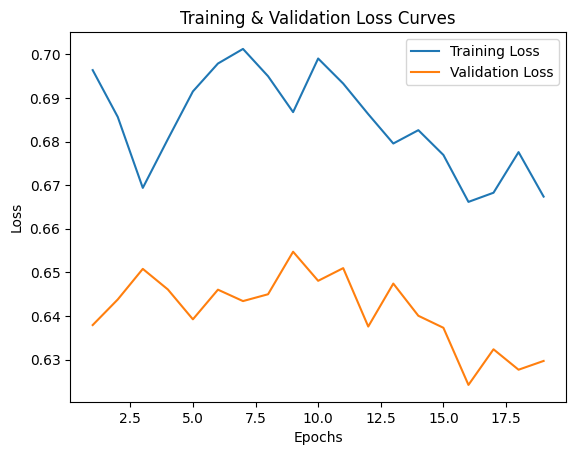

In [40]:
from matplotlib import pyplot as plt


plt.plot(epoch_count[1:], train_loss_values[1:], label='Training Loss')
plt.plot(epoch_count[1:], valid_loss_values[1:], label='Validation Loss')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

#### Distribution of Weights and Biases

#### Weights

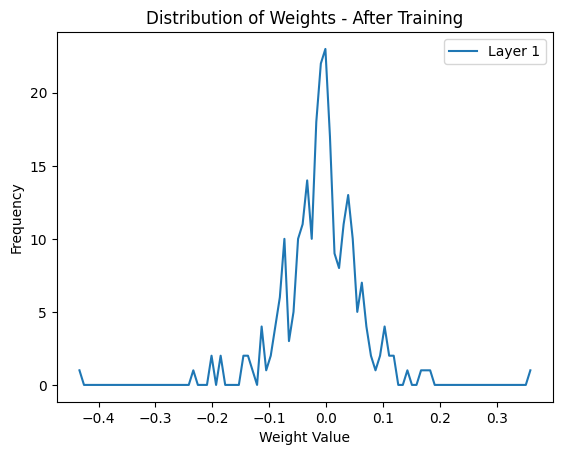

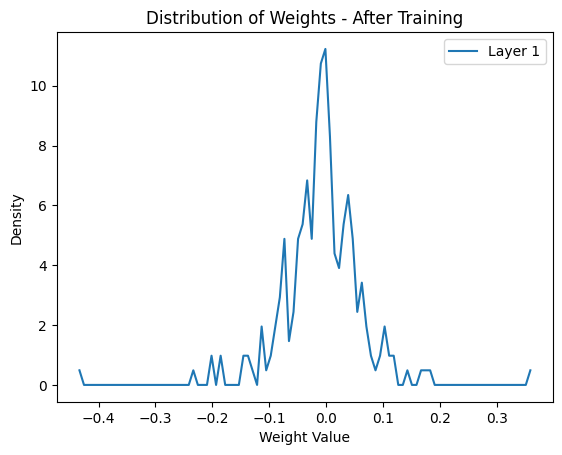

In [41]:
import sys
import os

sys.path.append(os.path.join(os.environ['SEPSIS_PREDICTOR_BASE'], "src"))

import Utils

plotData = {}
plotData['Layer 1'] = model.linear1.weight.data.flatten()
# plotData['Layer 2'] = model.linear2.weight.data.flatten()
# plotData['Layer 3'] = model.linear3.weight.data.flatten()

plt1 = Utils.plotWeightsDistribution(data=plotData, density=False, dataType="Weights", titlePrefix='After Training')
plt1.show()

plt2 = Utils.plotWeightsDistribution(data=plotData, density=True, dataType="Weights", titlePrefix='After Training')
plt2.show()

##### Biases

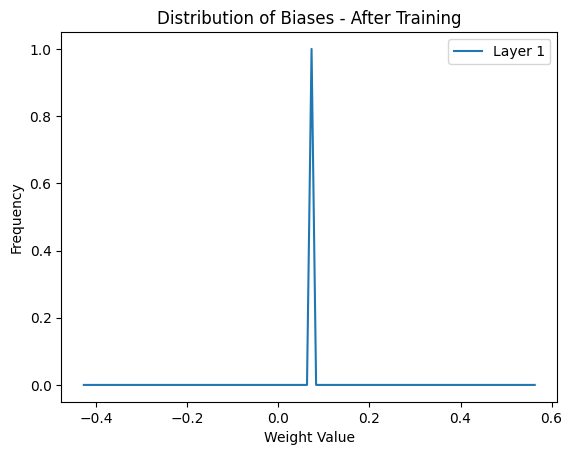

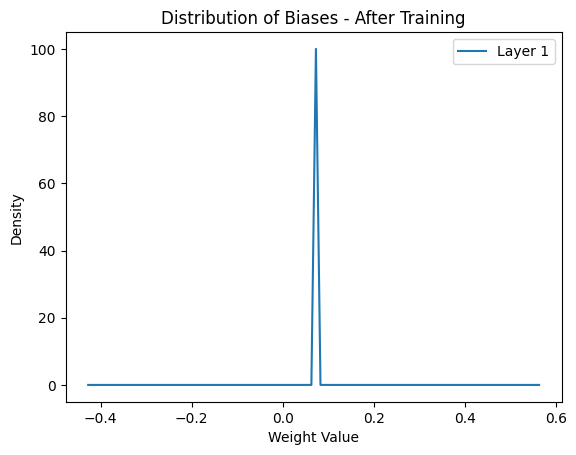

In [42]:
import sys
import os

sys.path.append(os.path.join(os.environ['SEPSIS_PREDICTOR_BASE'], "src"))

import Utils


plotData = {}
plotData['Layer 1'] = model.linear1.bias.data.flatten()
# plotData['Layer 2'] = model.linear2.bias.data.flatten()
# plotData['Layer 3'] = model.linear3.bias.data.flatten()

plt1 = Utils.plotWeightsDistribution(data=plotData, density=False, dataType="Biases", titlePrefix='After Training')
plt1.show()

plt1 = Utils.plotWeightsDistribution(data=plotData, density=True, dataType="Biases", titlePrefix='After Training')
plt1.show()

#### Distribution of Activations

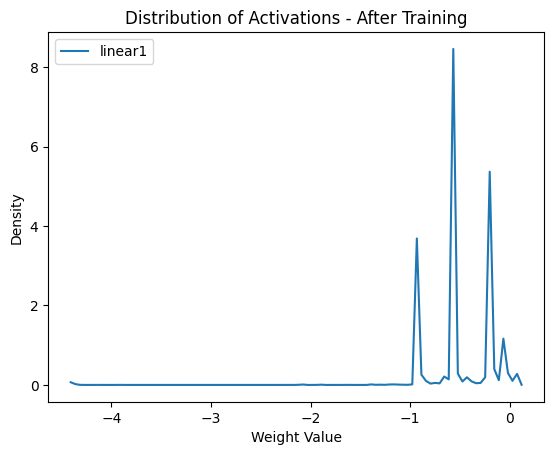

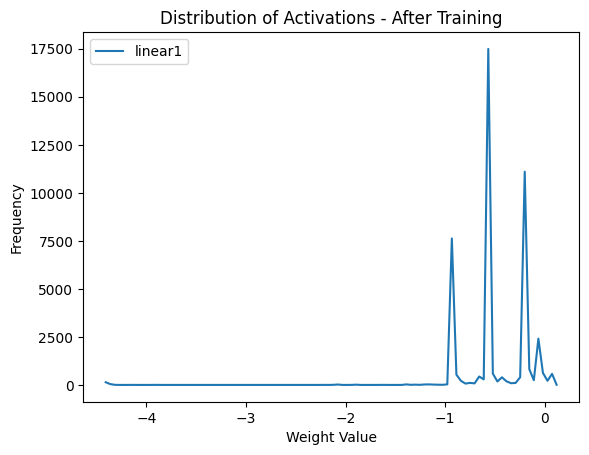

In [47]:
import sys
import os

sys.path.append(os.path.join(os.environ['SEPSIS_PREDICTOR_BASE'], "src"))

import Utils

activation = {}

def get_activation(name):
    def hook(module, input, output):
        activation[name] = output.detach()
    return hook

# Register the hooks
handle1 = model.linear1.register_forward_hook(get_activation('linear1'))
# handle2 = model.linear2.register_forward_hook(get_activation('linear2'))
# handle3 = model.linear3.register_forward_hook(get_activation('linear3'))

# Perform forward pass to get activations
with torch.no_grad():
    output = model(X_test_tensor)

handle1.remove()
# handle2.remove()
# handle3.remove()

plt1 = Utils.plotActivationDistribution(activation=activation, density=True, dataType="Activations", titlePrefix='After Training')
plt1.show()

plt2 = Utils.plotActivationDistribution(activation=activation, density=False, dataType="Activations", titlePrefix='After Training')
plt2.show()

#### Distribution of Gradients

In [48]:
all_grads = {}
for name, param in model.named_parameters():
    if param.grad is not None:
        if(not name in all_grads):
            all_grads[name] = [param.grad.detach().cpu().numpy().flatten()]
        else:
            all_grads[name].append(param.grad.detach().cpu().numpy().flatten())

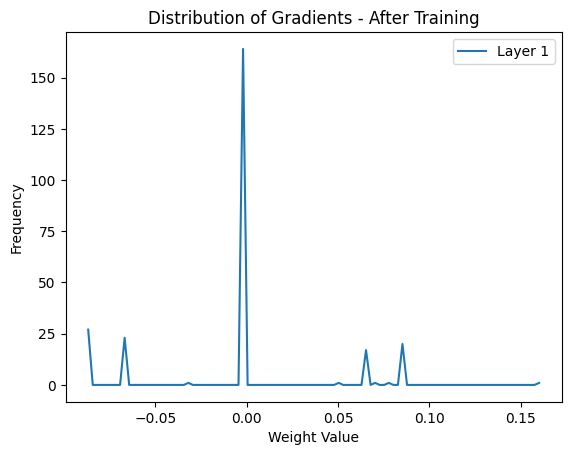

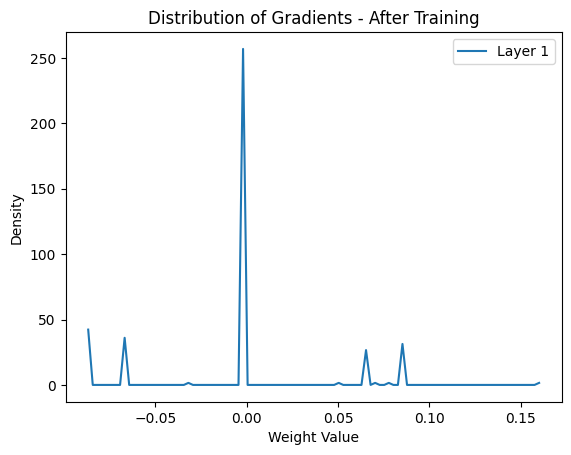

In [49]:
import sys
import os

sys.path.append(os.path.join(os.environ['SEPSIS_PREDICTOR_BASE'], "src"))

import Utils


plotData = {
    'Layer 1': torch.tensor(all_grads['linear1.weight']),
    # 'Layer 2': torch.tensor(all_grads['linear2.weight']),
    # 'Layer 3': torch.tensor(all_grads['linear3.weight']),
}

plt1 = Utils.plotWeightsDistribution(data=plotData, density=False, dataType="Gradients", titlePrefix='After Training')
plt1.show()

plt2 = Utils.plotWeightsDistribution(data=plotData, density=True, dataType="Gradients", titlePrefix='After Training')
plt2.show()

#### Plotting weight update ratio (ΔW/W)

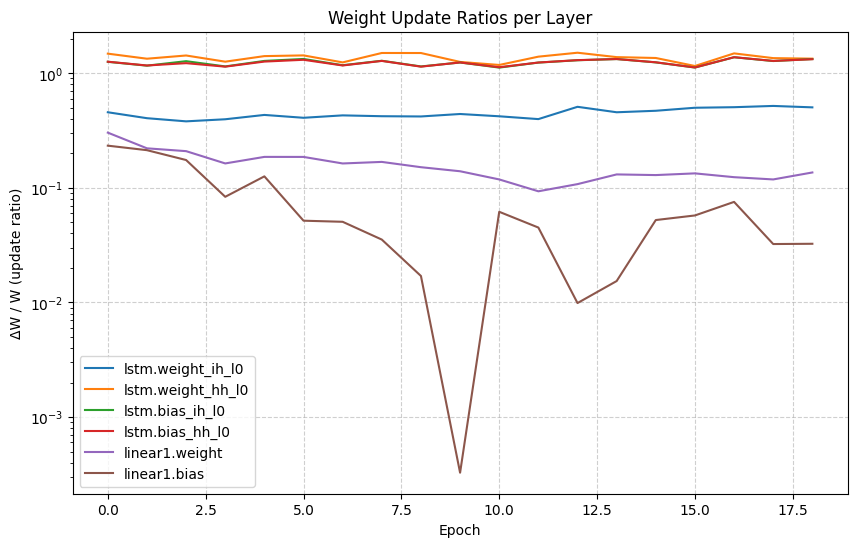

In [50]:
plt.figure(figsize=(10, 6))
for name, ratios in update_ratios.items():
    plt.plot(ratios, label=name)

plt.xlabel("Epoch")
plt.ylabel("ΔW / W (update ratio)")
plt.title("Weight Update Ratios per Layer")
plt.yscale("log")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
